# Seq2Seq models (Sequence-to-Sequence)

Sequence to sequence models are a variant of deep learning models that consists of an encoder and a decoder. They are used for problems that map an abitrarily long sequence to another arbitrarliy long sequence. For example, in machine translation, you convert a sequence of words in a source language to a sequence of words in a target language. Here we will see how we can use a seq2seq model to solve a machine translation task to convert English to German.


<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/manning_tf2_in_action/blob/master/Ch11/11.1_Seq2seq_machine_translation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>



In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import time

def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")
 
# Fixing the random seed
random_seed=4321
fix_random_seed(random_seed)


2.4.1


http://www.manythings.org/anki/
    
german-english

In [2]:
# Not setting this led to the following error
# _Derived_]RecvAsync is cancelled.   
# [[{{node gradient_tape/model_1/embedding_1/embedding_lookup/Reshape/_172}}]] [Op:__inference_train_function_31985]

%env TF_FORCE_GPU_ALLOW_GROWTH=true

env: TF_FORCE_GPU_ALLOW_GROWTH=true


## Loading the data (Requires manual download)

Unfortunately, this dataset **must be manually downloaded** by clicking [this link](http://www.manythings.org/anki/deu-eng.zip). Then place the downloaded `deu-eng.zip` file in the `Ch11/data` folder before running the cell below.


In [3]:
import os
import requests
import zipfile

# Make sure the zip file has been downloaded
if not os.path.exists(os.path.join('data','deu-eng.zip')):
    raise FileNotFoundError(
        "Uh oh! Did you download the deu-eng.zip from http://www.manythings.org/anki/deu-eng.zip manually and place it in the Ch11/data folder?"
    )

else:
    if not os.path.exists(os.path.join('data', 'deu.txt')):
        with zipfile.ZipFile(os.path.join('data','deu-eng.zip'), 'r') as zip_ref:
            zip_ref.extractall('data')
    else:
        print("The extracted data already exists")

The extracted data already exists


## Reading the data

Data is in a single `.txt` file. It is a parallel corpus meaning there is a English sentence/phrase/paragraph and a corresponding German translation of it side-by-side. In the file, the source input and the translation are separated by a tab (i.e. tab-seperated file)

In [4]:
import pandas as pd

# Read the csv file
df = pd.read_csv(os.path.join('data', 'deu.txt'), delimiter='\t', header=None)
# Set column names
df.columns = ["EN", "DE", "Attribution"]
df = df[["EN", "DE"]]
print('df.shape = {}'.format(df.shape))

df.shape = (227080, 2)


In [5]:
df.head()

,EN,DE
0,Go.,Geh.
1,Hi.,Hallo!
2,Hi.,Grüß Gott!
3,Run!,Lauf!
4,Run.,Lauf!


## Use a smaller sample for computational speed

In [6]:
df = df.iloc[1000:].sample(n=50000, random_state=random_seed)

## Introducing the `SOS` and `EOS` tokens (Decoder)

We will add these special tokens to the translated targets. `sos` indicates the start of the sentence and `eos` marks the end of the sentence. 

E.g. `Grüß Gott!` becomes `sos Grüß Gott! eos`

In [7]:
df["DE"] = 'sos ' + df["DE"] + ' eos'

## Splitting training/validation/testing data

In [8]:
# Randomly sample 5000 examples from the total 50000 randomly
test_df = df.sample(n=5000, random_state=random_seed)
# Randomly sample 5000 examples from the total 50000 randomly
valid_df = df.loc[~df.index.isin(test_df.index)].sample(n=5000, random_state=random_seed)
# Assign the rest to training data
train_df = df.loc[~(df.index.isin(test_df.index) | df.index.isin(valid_df.index))]

print('test_df.shape = {}'.format(test_df.shape))
print('valid_df.shape = {}'.format(valid_df.shape))
print('train_df.shape = {}'.format(train_df.shape))

test_df.shape = (5000, 2)
valid_df.shape = (5000, 2)
train_df.shape = (40000, 2)


## Analysing the vocabulary sizes (English and German)

In [9]:
from collections import Counter

# Create a flattened list from English words
en_words = train_df["EN"].str.split().sum()
# Create a flattened list of German words
de_words = train_df["DE"].str.split().sum()

# Get the vocabulary size of words appearing more than or equal to 10 times
n=10

def get_vocabulary_size_greater_than(words, n, verbose=True):
    
    """ Get the vocabulary size above a certain threshold """
    
    # Generate a counter object i.e. dict word -> frequency
    counter = Counter(words)
    
    # Create a pandas series from the counter, then sort most frequent to least
    freq_df = pd.Series(list(counter.values()), index=list(counter.keys())).sort_values(ascending=False)
    
    if verbose:
        # Print most common words
        print(freq_df.head(n=10))

    # Count of words >= n frequent    
    n_vocab = (freq_df>=n).sum()
    
    if verbose:
        print("\nVocabulary size (>={} frequent): {}".format(n, n_vocab))
        
    return n_vocab

print("English corpus")
print('='*50)
en_vocab = get_vocabulary_size_greater_than(en_words, n)

print("\nGerman corpus")
print('='*50)
de_vocab = get_vocabulary_size_greater_than(de_words, n)

English corpus
Tom    9506
to     8831
I      8368
the    6982
you    6076
a      5653
is     4311
in     2733
of     2676
was    2318
dtype: int64

Vocabulary size (>=10 frequent): 2249

German corpus
sos      40000
eos      40000
Tom       9968
Ich       7813
ist       4668
nicht     4576
zu        3712
Sie       3380
du        3083
das       2933
dtype: int64

Vocabulary size (>=10 frequent): 2456


## Analysing the sequence length (English and German)

In [10]:
def print_sequence_length(str_ser):
    
    """ Print the summary stats of the sequence length """
    
    # Create a pd.Series, which contain the sequence length for each review
    seq_length_ser = str_ser.str.split(' ').str.len()

    # Get the median as well as summary statistics of the sequence length
    print("\nSome summary statistics")
    print("Median length: {}\n".format(seq_length_ser.median()))
    print(seq_length_ser.describe())
    
    # Get the quantiles at given marks
    print("\nComputing the statistics between the 1% and 99% quantiles (to ignore outliers)")
    p_01 = seq_length_ser.quantile(0.01)
    p_99 = seq_length_ser.quantile(0.99)
    
    # Print the summary stats of the data between the defined quantlies
    print(seq_length_ser[(seq_length_ser >= p_01) & (seq_length_ser < p_99)].describe())

print("English corpus")
print('='*50)
print_sequence_length(train_df["EN"])

print("\nGerman corpus")
print('='*50)
print_sequence_length(train_df["DE"])

English corpus

Some summary statistics
Median length: 6.0

count    40000.000000
mean         6.371500
std          2.616927
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max        101.000000
Name: EN, dtype: float64

Computing the statistics between the 1% and 99% quantiles (to ignore outliers)
count    39545.000000
mean         6.249766
std          2.313737
min          2.000000
25%          5.000000
50%          6.000000
75%          8.000000
max         14.000000
Name: EN, dtype: float64

German corpus

Some summary statistics
Median length: 8.0

count    40000.00000
mean         8.40025
std          2.58841
min          3.00000
25%          7.00000
50%          8.00000
75%         10.00000
max         77.00000
Name: DE, dtype: float64

Computing the statistics between the 1% and 99% quantiles (to ignore outliers)
count    39271.000000
mean         8.307708
std          2.279042
min          5.000000
25%          7.000000
50%          8.

## Printing the vocabulary size and sequence length

In [11]:
print("EN vocabulary size: {}".format(en_vocab))
print("DE vocabulary size: {}".format(de_vocab))

# Define sequence lengths with some extra space for longer sequences
en_seq_length = 19
de_seq_length = 21

print("EN max sequence length: {}".format(en_seq_length))
print("DE max sequence length: {}".format(de_seq_length))

EN vocabulary size: 2249
DE vocabulary size: 2456
EN max sequence length: 19
DE max sequence length: 21


## TensorFlow `TextVectorization` layer

In [12]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

print("Defined the vectorization layer for English")

# Create the text vectorization layer (English)
en_vectorize_layer = TextVectorization(
    max_tokens=en_vocab,
    output_mode='int',
    output_sequence_length=None
)

print("Fitting the EN vectorization layer on data")
# Here we are calling adapt to fit the vectorization layer with text
# so that it learns the vocabulary
en_vectorize_layer.adapt(np.array(train_df["EN"].tolist()).astype('str'))
print("\tDone")

print("\nDefined the vectorization layer for German")

# Create the text vectorization layer (German)
de_vectorize_layer = TextVectorization(
    max_tokens=de_vocab,    
    output_mode='int',
    output_sequence_length=de_seq_length,
    pad_to_max_tokens=False,
)

print("Fitting the DE vectorization layer on data")
de_vectorize_layer.adapt(np.array(train_df["DE"].tolist()).astype('str'))
print("\tDone")

Defined the vectorization layer for English
Fitting the EN vectorization layer on data
	Done

Defined the vectorization layer for German
Fitting the DE vectorization layer on data
	Done


## `TextVectorization` layer in action
 
### How to use the layer (EN)

In [13]:
import tensorflow.keras.backend as K
K.clear_session()

# Create the model that uses the vectorize text layer
toy_model = tf.keras.models.Sequential()

# Start by creating an explicit input layer. It needs to have a shape of
# (1,) (because we need to guarantee that there is exactly one string
# input per batch), and the dtype needs to be 'string'.
toy_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# The first layer in our model is the vectorization layer. After this
# layer, we have a tensor of shape (batch_size, max_len) containing vocab
# indices.
toy_model.add(en_vectorize_layer)

# Now, the model can map strings to integers, 
input_data = [["run"], ["I\'ll go home"],["ectoplasmic residue"]]
pred = toy_model.predict(input_data)

print("Input data: \n{}\n".format(input_data))
print("\nToken IDs: \n{}".format(pred))

Input data: 
[['run'], ["I'll go home"], ['ectoplasmic residue']]


Token IDs: 
[[486   0   0]
 [ 79  47 106]
 [  1   1   0]]


### How to use the layer (DE)

In [14]:
import tensorflow.keras.backend as K
K.clear_session()

# Create the model that uses the vectorize text layer
toy_model = tf.keras.models.Sequential()

# Start by creating an explicit input layer. It needs to have a shape of
# (1,) (because we need to guarantee that there is exactly one string
# input per batch), and the dtype needs to be 'string'.
toy_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# The first layer in our model is the vectorization layer. After this
# layer, we have a tensor of shape (batch_size, max_len) containing vocab
# indices.
toy_model.add(de_vectorize_layer)

# Now, the model can map strings to integers, 
input_data = [["[sos] Geh"], ["geh lauf"]]
pred = toy_model.predict(input_data)

print("Input data: \n{}\n".format(input_data))
print("\nToken IDs: \n{}".format(pred))

Input data: 
[['[sos] Geh'], ['geh lauf']]


Token IDs: 
[[  2 825   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [825   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]]


### Sample of the vocabulary

In [15]:
print("English")
# Print first few words in the vocabulary
print(en_vectorize_layer.get_vocabulary()[:10])
# Print the size of the vocabulary
print(len(en_vectorize_layer.get_vocabulary()))

print("\nGerman")
# Print first few words in the vocabulary
print(de_vectorize_layer.get_vocabulary()[:10])
# Print the size of the vocabulary
print(len(de_vectorize_layer.get_vocabulary()))

English
['', '[UNK]', 'tom', 'to', 'you', 'the', 'i', 'a', 'is', 'that']
2249

German
['', '[UNK]', 'sos', 'eos', 'ich', 'tom', 'nicht', 'ist', 'das', 'du']
2456


## Defining the Seq2Seq model

Encoder decoder
Uses internal vectorizers in both encoder and decoder
Bidirectional encoder

In [16]:
import tensorflow.keras.backend as K
K.clear_session()

def get_vectorizer(list_of_strings, n_vocab, max_length=None, return_vocabulary=True, name=None):
    
    """ Return a text vectorization layer or a model """
    
    # Definie an input layer that takes a list of strings (or an array of strings)
    inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='encoder_input')
    
    # When defining the vocab size, we'd add two for special tokens '' (Padding) and '[UNK]' (Oov tokens)
    vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=n_vocab+2,
        output_mode='int',
        output_sequence_length=max_length,                
    )
    
    # Fit the vectorizer layer on the data
    vectorize_layer.adapt(list_of_strings)
        
    # Get the token IDs
    vectorized_out = vectorize_layer(inp)
        
    if not return_vocabulary: 
        return tf.keras.models.Model(inputs=inp, outputs=vectorized_out, name=name)    
    else:
        # Returns the vocabulary in addition to the model
        return tf.keras.models.Model(inputs=inp, outputs=vectorized_out, name=name), vectorize_layer.get_vocabulary()
    
        
def get_encoder_and_state(n_vocab, vectorizer):
    """ Define the encoder of the seq2seq model"""
    
    # The input is (None,1) shaped and accepts an array of strings
    inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='e_input')

    # Vectorize the data (assign token IDs)
    vectorized_out = vectorizer(inp)
    
    # Define an embedding layer to convert IDs to word vectors
    emb_layer = tf.keras.layers.Embedding(n_vocab+2, 128, mask_zero=True, name='e_embedding')
    # Get the embeddings of the token IDs
    emb_out = emb_layer(vectorized_out)
    
    # Define a bidirectional GRU layer
    # Encoder looks at the english text (i.e. the input) both backwards and forward
    # this leads to better performance
    gru_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, name='e_gru'), name='e_bidirectional_gru')
    
    # Get the output of the gru layer
    gru_out = gru_layer(emb_out)
    
    # Define the encoder model
    encoder = tf.keras.models.Model(inputs=inp, outputs=gru_out, name='encoder')
        
    # We are also returning the final state of the encoder as that
    # is passed as the initial state to the decoder
    return encoder


def get_final_seq2seq_model(n_vocab, encoder, vectorizer):
    """ Define the final encoder-decoder model """
    
    # Encoder's input
    e_inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='e_input_final')    
    # Get the encoders final output
    d_init_state = encoder(e_inp)
    
    # The input is (None,1) shaped and accepts an array of strings
    # This input layer is used to train the seq2seq model with teacher-forcing
    # we feed the German sequence as the input and ask the model to predict 
    # it with the words offset by 1 (i.e. next word)
    inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='d_input')
    
    # Vectorize the data (assign token IDs)
    vectorized_out = vectorizer(inp)
    
    # Define an embedding layer to convert IDs to word vectors
    # Note that this is a different embedding layer to the encoder's embedding layer
    emb_layer = tf.keras.layers.Embedding(n_vocab+2, 128, mask_zero=True, name='d_embedding')
    
    # Get the embeddings of the token IDs
    emb_out = emb_layer(vectorized_out)
    
    # Define a GRU layer
    # Unlike the encoder, we cannot define a bidirectional GRU for the decoder
    # Why?
    gru_layer = tf.keras.layers.GRU(256, return_sequences=True, name='d_gru')
    
    # Get the output of the gru layer
    gru_out = gru_layer(emb_out, initial_state=d_init_state)
    
    # Define an intermediate dense layer
    dense_layer_1 = tf.keras.layers.Dense(512, activation='relu', name='d_dense_1')
    dense1_out = dense_layer_1(gru_out)
    
    # The final prediction layer with softmax
    dense_layer_final = tf.keras.layers.Dense(n_vocab+2, activation='softmax', name='d_dense_final')
    dense_final_out = dense_layer_final(dense1_out)
    
    # Define the full model
    seq2seq = tf.keras.models.Model(inputs=[e_inp, inp], outputs=dense_final_out, name='final_seq2seq')
    
    return seq2seq

# Get the English vectorizer/vocabulary
en_vectorizer, en_vocabulary = get_vectorizer(np.array(train_df["EN"].tolist()), en_vocab, max_length=en_seq_length, name='e_vectorizer')
# Get the German vectorizer/vocabulary
de_vectorizer, de_vocabulary = get_vectorizer(np.array(train_df["DE"].tolist()), de_vocab, max_length=de_seq_length-1, name='d_vectorizer')

# Define the final model
encoder = get_encoder_and_state(en_vocab, en_vectorizer)
final_model = get_final_seq2seq_model(de_vocab, encoder, de_vectorizer)


## Compile the model

In [33]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Compile the model
final_model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
final_model.summary()

Model: "final_seq2seq"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
d_input (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
d_vectorizer (Functional)       (None, 20)           0           d_input[0][0]                    
__________________________________________________________________________________________________
e_input_final (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
d_embedding (Embedding)         (None, 20, 128)      314624      d_vectorizer[0][0]               
______________________________________________________________________________________

## Evaluating MT models - BLEU metric

https://github.com/tensorflow/nmt/blob/master/nmt/scripts/bleu.py

### Defining the BLEU metric

In [29]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from bleu import compute_bleu

class BLEUMetric(object):
    
    def __init__(self, vocabulary, name='perplexity', **kwargs):
      """ Computes the BLEU score (Metric for machine translation) """
      super().__init__()
      self.vocab = vocabulary
      self.id_to_token_layer = StringLookup(vocabulary=self.vocab, invert=True)
    
    def calculate_bleu_from_predictions(self, real, pred):
        """ Calculate the BLEU score for targets and predictions """
        
        # Get the predicted token IDs
        pred_argmax = tf.argmax(pred, axis=-1)  
        
        # Convert token IDs to words using the vocabulary and the StringLookup
        pred_tokens = self.id_to_token_layer(pred_argmax)
        real_tokens = self.id_to_token_layer(real)
        
        def clean_text(tokens):
            
            """ Clean padding and [SOS]/[EOS] tokens to only keep meaningful words """
            
            # 3. Strip the string of any extra white spaces
            t = tf.strings.strip(
                        # 2. Replace everything after the eos token with blank
                        tf.strings.regex_replace(
                            # 1. Join all the tokens to one string in each sequence
                            tf.strings.join(
                                tf.transpose(tokens), separator=' '
                            ),
                        "eos.*", ""),
                   )
            
            # Decode the byte stream to a string
            t = np.char.decode(t.numpy().astype(np.bytes_), encoding='utf-8')
            
            # If the string is empty, add a [UNK] token
            # Otherwise get a Division by zero error
            t = [doc if len(doc)>0 else '[UNK]' for doc in t ]
            
            # Split the sequences to individual tokens 
            t = np.char.split(t).tolist()
            
            return t
        
        # Get the clean versions of the predictions and real seuqences
        pred_tokens = clean_text(pred_tokens)
        # We have to wrap each real sequence in a list to make use of a function to compute bleu
        real_tokens = [[r] for r in clean_text(real_tokens)]
        
        # The compute_bleu method accpets the translations and references in the following format
        # tranlation - list of list of tokens
        # references - list of list of list of tokens
        bleu, precisions, bp, ratio, translation_length, reference_length = compute_bleu(real_tokens, pred_tokens, smooth=False)

        return bleu

### Using the BLEU metric

In [30]:
translation = [['[UNK]', 'einmal', 'mÃ¼ssen', 'wir', 'in', 'erfahrung', 'bringen', 'wo', 'sie', 'wohnen']]
reference = [[['als', 'mÃ¼ssen', 'mÃ¼ssen', 'wir', 'in', 'erfahrung', 'bringen', 'wo', 'sie', 'wohnen']]]

compute_bleu(reference, translation)

(0.7598356856515925,
 [0.8, 0.7777777777777778, 0.75, 0.7142857142857143],
 1.0,
 1.0,
 10,
 10)

## Training the model with a custom loop

In [34]:
import time

epochs = 5
batch_size = 128


def prepare_data(train_df, valid_df, test_df):
    """ Create a data dictionary from the dataframes containing data """
    
    data_dict = {}
    for label, df in zip(['train', 'valid', 'test'], [train_df, valid_df, test_df]):
        en_inputs = np.array(df["EN"].tolist())
        de_inputs = np.array(df["DE"].str.rsplit(n=1, expand=True).iloc[:,0].tolist())
        de_labels = np.array(df["DE"].str.split(n=1, expand=True).iloc[:,1].tolist())
        data_dict[label] = {'encoder_inputs': en_inputs, 'decoder_inputs': de_inputs, 'decoder_labels': de_labels}
    
    return data_dict


def shuffle_data(en_inputs, de_inputs, de_labels, shuffle_inds=None): 
    """ Shuffle the data randomly (but all of inputs and labels at ones)"""
        
    if shuffle_inds is None:
        # If shuffle_inds are not passed create a shuffling automatically
        shuffle_inds = np.random.permutation(np.arange(en_inputs.shape[0]))
    else:
        # Shuffle the provided shuffle_inds
        shuffle_inds = np.random.permutation(shuffle_inds)
    
    # Return shuffled data
    return (en_inputs[shuffle_inds], de_inputs[shuffle_inds], de_labels[shuffle_inds]), shuffle_inds


def evaluate_model(model, vectorizer, en_inputs_raw, de_inputs_raw, de_labels_raw, epochs, batch_size):
    
    # Define the metric
    bleu_metric = BLEUMetric(de_vocabulary)
    
    loss_log, accuracy_log, bleu_log = [], [], []
    # Get the number of validation batches
    n_batches = en_inputs_raw.shape[0]//batch_size
    print(" ", end='\r')

    # Evaluate one validation batch at a time
    for i in range(n_batches):
        # Status update
        print("Evaluating batch {}/{}".format(i+1, n_batches), end='\r')

        # Get the inputs and targers
        x = [en_inputs_raw[i*batch_size:(i+1)*batch_size], de_inputs_raw[i*batch_size:(i+1)*batch_size]]
        y = vectorizer(de_labels_raw[i*batch_size:(i+1)*batch_size])

        # Get the evaluation metrics
        loss, accuracy = model.evaluate(x, y, verbose=0)
        # Get the predictions to compute BLEU
        pred_y = model.predict(x)

        # Update validation logs
        loss_log.append(loss)
        accuracy_log.append(accuracy)
        bleu_log.append(bleu_metric.calculate_bleu_from_predictions(y, pred_y))
    
    return np.mean(loss_log), np.mean(accuracy_log), np.mean(bleu_log)
    
        
def train_model(model, vectorizer, train_df, valid_df, test_df, epochs, batch_size):
    """ Training the model """
    
    # Define the metric
    bleu_metric = BLEUMetric(de_vocabulary)

    # Define the data
    data_dict = prepare_data(train_df, valid_df, test_df)

    shuffle_inds = None
    
    
    for epoch in range(epochs):

        # Reset metric logs every epoch
        bleu_log = []
        accuracy_log = []
        loss_log = []

        # =================================================================== #
        #                         Train Phase                                 #
        # =================================================================== #

        # Shuffle data at the beginning of every epoch
        (en_inputs_raw,de_inputs_raw,de_labels_raw), shuffle_inds  = shuffle_data(
            data_dict['train']['encoder_inputs'],
            data_dict['train']['decoder_inputs'],
            data_dict['train']['decoder_labels'],
            shuffle_inds
        )

        # Get the number of training batches
        n_train_batches = en_inputs_raw.shape[0]//batch_size

        # Train one batch at a time
        for i in range(n_train_batches):
            # Status update
            print("Training batch {}/{}".format(i+1, n_train_batches), end='\r')

            # Get a batch of inputs (english and german sequences)
            x = [en_inputs_raw[i*batch_size:(i+1)*batch_size], de_inputs_raw[i*batch_size:(i+1)*batch_size]]
            # Get a batch of targets (german sequences offset by 1)
            y = vectorizer(de_labels_raw[i*batch_size:(i+1)*batch_size])

            # Train for a single step
            model.train_on_batch(x, y)        
            # Evaluate the model to get the metrics
            loss, accuracy = model.evaluate(x, y, verbose=0)
            # Get the final prediction to compute BLEU
            pred_y = model.predict(x)

            # Update the epoch's log records of the metrics
            loss_log.append(loss)
            accuracy_log.append(accuracy)
            bleu_log.append(bleu_metric.calculate_bleu_from_predictions(y, pred_y))

        # =================================================================== #
        #                      Validation Phase                               #
        # =================================================================== #
        
        val_en_inputs = data_dict['valid']['encoder_inputs']
        val_de_inputs = data_dict['valid']['decoder_inputs']
        val_de_labels = data_dict['valid']['decoder_labels']
            
        val_loss, val_accuracy, val_bleu = evaluate_model(
            model, vectorizer, val_en_inputs, val_de_inputs, val_de_labels, epochs, batch_size
        )
            
        # Print the evaluation metrics of each epoch
        print("\nEpoch {}/{}".format(epoch+1, epochs))
        print("\t(train) loss: {} - accuracy: {} - bleu: {}".format(np.mean(loss_log), np.mean(accuracy_log), np.mean(bleu_log)))
        print("\t(valid) loss: {} - accuracy: {} - bleu: {}".format(val_loss, val_accuracy, val_bleu))
    
    # =================================================================== #
    #                      Test Phase                                     #
    # =================================================================== #    
    
    test_en_inputs = data_dict['test']['encoder_inputs']
    test_de_inputs = data_dict['test']['decoder_inputs']
    test_de_labels = data_dict['test']['decoder_labels']
            
    test_loss, test_accuracy, test_bleu = evaluate_model(
            model, vectorizer, test_en_inputs, test_de_inputs, test_de_labels, epochs, batch_size
    )
    
    print("\n(test) loss: {} - accuracy: {} - bleu: {}".format(test_loss, test_accuracy, test_bleu))

t1 = time.time()    
train_model(final_model, de_vectorizer, train_df, valid_df, test_df, epochs, batch_size)
t2 = time.time()

print("\nIt took {} seconds to complete the training".format(t2-t1))

Evaluating batch 39/39
Epoch 1/5
	(train) loss: 1.7673478011901562 - accuracy: 0.24513264504285195 - bleu: 0.002179387607593193
	(valid) loss: 1.4485881817646515 - accuracy: 0.33110261345520997 - bleu: 0.01199333936034144
Evaluating batch 39/39
Epoch 2/5
	(train) loss: 1.3196139595447443 - accuracy: 0.3695648503609193 - bleu: 0.030331061497335617
	(valid) loss: 1.212600277020381 - accuracy: 0.40372603902449977 - bleu: 0.047088649383548294
Evaluating batch 39/39
Epoch 3/5
	(train) loss: 1.1058441591568482 - accuracy: 0.43287440026417756 - bleu: 0.06973255766539602
	(valid) loss: 1.0736533525662544 - accuracy: 0.4464820676889175 - bleu: 0.07360283948444667
Evaluating batch 39/39
Epoch 4/5
	(train) loss: 0.947786437968413 - accuracy: 0.4818474271167547 - bleu: 0.10347354581510186
	(valid) loss: 0.9735986498685983 - accuracy: 0.48121631680390775 - bleu: 0.10747072579117517
Evaluating batch 39/39
Epoch 5/5
	(train) loss: 0.8230568886949465 - accuracy: 0.5244687414513185 - bleu: 0.1367169205

## Save the trained model

In [21]:
## Save the model
os.makedirs('models', exist_ok=True)
tf.keras.models.save_model(final_model, os.path.join('models', 'seq2seq'))

import json
os.makedirs(os.path.join('models', 'seq2seq_vocab'), exist_ok=True)

with open(os.path.join('models', 'seq2seq_vocab', 'en_vocab.json'), 'w') as f:
    json.dump(en_vocabulary, f)    
with open(os.path.join('models', 'seq2seq_vocab', 'de_vocab.json'), 'w') as f:
    json.dump(de_vocabulary, f)

## Defining the inference model

In [23]:
import tensorflow.keras.backend as K
K.clear_session()

def get_inference_model(save_path):
    
    model = tf.keras.models.load_model(save_path)
    
    en_model = model.get_layer("encoder")
    
    inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='d_infer_input')
    d_state_inp = tf.keras.Input(shape=(256,), name='d_infer_state')
    
    d_vec_layer = model.get_layer('d_vectorizer')    
    d_vec_out = d_vec_layer(inp)
    
    d_emb_out = model.get_layer('d_embedding')(d_vec_out)
        
    d_gru_layer = model.get_layer("d_gru")#.get_weights()
    
    #d_gru_layer = tf.keras.layers.GRU(256)    
    #d_gru_layer.initial_state = d_state_inp
    d_gru_layer.return_sequences = False
    d_gru_out = d_gru_layer(d_emb_out, initial_state=d_state_inp) 
    
    d_dense1_out = model.get_layer("d_dense_1")(d_gru_out) 
    
    d_final_out = model.get_layer("d_dense_final")(d_dense1_out) 
    
    de_model = tf.keras.models.Model(inputs=[inp, d_state_inp], outputs=[d_final_out, d_gru_out])
    
    return en_model, de_model

def get_vocabularies(save_dir):
    
    with open(os.path.join(save_dir, 'en_vocab.json'), 'r') as f:
        en_vocabulary = json.load(f)
        
    with open(os.path.join(save_dir, 'de_vocab.json'), 'r') as f:
        de_vocabulary = json.load(f)
        
    return en_vocabulary, de_vocabulary

print("Loading vocabularies")
en_vocabulary, de_vocabulary = get_vocabularies(os.path.join('models', 'seq2seq_vocab'))

print("Loading weights and generating the inference model")
en_model, de_model = get_inference_model(os.path.join('models', 'seq2seq'))


Loading vocabularies
Loading weights and generating the inference model


## Generating new translations

In [39]:
def generate_new_translation(en_model, de_model, sample_en_text):

    print("Input: {}".format(sample_en_text))

    d_state = en_model.predict(np.array([sample_en_text]))
    de_word = 'sos'
    de_translation = []

    while de_word != 'eos':

        de_pred, d_state = de_model.predict([np.array([de_word]), d_state])    
        de_word = de_vocabulary[np.argmax(de_pred[0])]
        de_translation.append(de_word)

    print("Translation: {}\n".format(' '.join(de_translation)))

for i in range(5):
    sample_en_text = test_df["EN"].iloc[i]
    generate_new_translation(en_model, de_model, sample_en_text)

Input: Tom seems to think that he's invincible.
Translation: tom scheint zu [UNK] zu sein eos

Input: I don't want to go to jail.
Translation: ich will nicht nach boston gehen eos

Input: Tom needs to act quickly.
Translation: tom muss sich [UNK] eos

Input: Tom didn't know what Mary was talking about.
Translation: tom wusste nicht was mary zu helfen hat eos

Input: I respect you for what you have done.
Translation: ich bin froh was du es getan hast eos



## Seq2Seq model with Attention

In [40]:
from attention import AttentionLayer

import tensorflow.keras.backend as K
K.clear_session()

def get_vectorizer(list_of_strings, n_vocab, max_length=None, return_vocabulary=True, name=None):
    
    """ Return a text vectorization layer or a model """
    
    # Definie an input layer that takes a list of strings (or an array of strings)
    inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='encoder_input')
    
    # When defining the vocab size, we'd add two for special tokens '' (Padding) and '[UNK]' (Oov tokens)
    vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=n_vocab+2,
        output_mode='int',
        output_sequence_length=max_length,                
    )
    
    # Fit the vectorizer layer on the data
    vectorize_layer.adapt(list_of_strings)
        
    # Get the token IDs
    vectorized_out = vectorize_layer(inp)
        
    if not return_vocabulary: 
        return tf.keras.models.Model(inputs=inp, outputs=vectorized_out, name=name)    
    else:
        # Returns the vocabulary in addition to the model
        return tf.keras.models.Model(inputs=inp, outputs=vectorized_out, name=name), vectorize_layer.get_vocabulary()
    
        
def get_encoder_with_attention(n_vocab, vectorizer):
    """ Define the encoder of the seq2seq model"""
    
    # The input is (None,1) shaped and accepts an array of strings
    inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='e_input')

    # Vectorize the data (assign token IDs)
    vectorized_out = vectorizer(inp)
    
    # Define an embedding layer to convert IDs to word vectors
    emb_layer = tf.keras.layers.Embedding(n_vocab+2, 128, mask_zero=True, name='e_embedding')
    # Get the embeddings of the token IDs
    emb_out = emb_layer(vectorized_out)
    
    # Define a bidirectional GRU layer
    # Encoder looks at the english text (i.e. the input) both backwards and forward
    # this leads to better performance
    gru_layer = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(128, return_sequences=True, return_state=True, name='e_gru'), 
        name='e_bidirectional_gru'
    )
    
    # Get the output of the gru layer
    gru_out_sequence, gru_fwd_out, gru_bwd_out = gru_layer(emb_out)
    # Define the encoder model
    encoder = tf.keras.models.Model(inputs=inp, outputs=[gru_fwd_out, gru_bwd_out, gru_out_sequence], name='encoder')
        
    # We are also returning the final state of the encoder as that
    # is passed as the initial state to the decoder
    return encoder


def get_final_seq2seq_model_with_attention(n_vocab, encoder, vectorizer):
    """ Define the final encoder-decoder model """
    
    e_inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='e_input_final')    
    fwd_state, bwd_state, en_states = encoder(e_inp)
    
    # The input is (None,1) shaped and accepts an array of strings
    # This input layer is used to train the seq2seq model with teacher-forcing
    # we feed the German sequence as the input and ask the model to predict 
    # it with the words offset by 1 (i.e. next word)
    inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='d_input')
    
    # Vectorize the data (assign token IDs)
    vectorized_out = vectorizer(inp)
    
    # Define an embedding layer to convert IDs to word vectors
    # Note that this is a different embedding layer to the encoder's embedding layer
    emb_layer = tf.keras.layers.Embedding(n_vocab+2, 128, mask_zero=True, name='d_embedding')
    
    # Get the embeddings of the token IDs
    emb_out = emb_layer(vectorized_out)
    
    # Define a GRU layer
    # Unlike the encoder, we cannot define a bidirectional GRU for the decoder
    # Why?
    gru_layer = tf.keras.layers.GRU(256, return_sequences=True, name='d_gru')
    
    # Get the output of the gru layer
    d_init_state = tf.keras.layers.Concatenate(axis=-1)([fwd_state, bwd_state])
    de_state = gru_layer(emb_out, initial_state=d_init_state)
    
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([en_states, de_state])
    
    #print(attn_out.shape)
    #print(de_state.shape)
    decoder_concat_input = tf.keras.layers.Concatenate(axis=-1, name='concat_layer')([de_state, attn_out])

    # Define an intermediate dense layer
    dense_layer_1 = tf.keras.layers.Dense(512, activation='relu', name='d_dense_1')
    dense1_out = dense_layer_1(decoder_concat_input)
    
    # The final prediction layer with softmax
    dense_layer_final = tf.keras.layers.Dense(n_vocab+2, activation='softmax', name='d_dense_final')
    dense_final_out = dense_layer_final(dense1_out)
    
    # Define the full model
    seq2seq = tf.keras.models.Model(inputs=[e_inp, inp], outputs=dense_final_out, name='final_seq2seq')
    
    return seq2seq

# Get the English vectorizer/vocabulary
en_vectorizer, en_vocabulary = get_vectorizer(np.array(train_df["EN"].tolist()), en_vocab, max_length=en_seq_length, name='e_vectorizer')
# Get the German vectorizer/vocabulary
de_vectorizer, de_vocabulary = get_vectorizer(np.array(train_df["DE"].tolist()), de_vocab, max_length=de_seq_length-1, name='d_vectorizer')

# Define the final model
encoder = get_encoder_with_attention(en_vocab, en_vectorizer)
final_model_with_attention = get_final_seq2seq_model_with_attention(de_vocab, encoder, de_vectorizer)


In [41]:
# Compile the model
final_model_with_attention.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
final_model_with_attention.summary()

Model: "final_seq2seq"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
d_input (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
e_input_final (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
d_vectorizer (Functional)       (None, 20)           0           d_input[0][0]                    
__________________________________________________________________________________________________
encoder (Functional)            [(None, 128), (None, 486272      e_input_final[0][0]              
______________________________________________________________________________________

In [42]:
epochs = 5
batch_size = 128

t1 = time.time()
train_model(final_model_with_attention, de_vectorizer, train_df, valid_df, test_df, epochs, batch_size)
t2 = time.time()

print("\nIt took {} seconds to complete the training".format(t2-t1))

Evaluating batch 39/39
Epoch 1/5
	(train) loss: 1.7329568889660714 - accuracy: 0.2647226378799249 - bleu: 0.00472143272555505
	(valid) loss: 1.4059809904832106 - accuracy: 0.3558326141956525 - bleu: 0.02620224793187979
Evaluating batch 39/39
Epoch 2/5
	(train) loss: 1.2265979938018017 - accuracy: 0.4132461631909395 - bleu: 0.0649594651608318
	(valid) loss: 1.0886339698082361 - accuracy: 0.46195775728959304 - bleu: 0.09881763329497112
Evaluating batch 39/39
Epoch 3/5
	(train) loss: 0.9293508781836584 - accuracy: 0.5138479712872933 - bleu: 0.14285005496217076
	(valid) loss: 0.8862711420426002 - accuracy: 0.529658331320836 - bleu: 0.13323894577232187
Evaluating batch 39/39
Epoch 4/5
	(train) loss: 0.7369613229082181 - accuracy: 0.586090661967412 - bleu: 0.20732611939912957
	(valid) loss: 0.7729042202998431 - accuracy: 0.5811995833348005 - bleu: 0.2061423912444988
Evaluating batch 39/39
Epoch 5/5
	(train) loss: 0.6236180976415292 - accuracy: 0.6333687748664465 - bleu: 0.2576824772799462
	(

In [43]:
## Save the model
os.makedirs('models', exist_ok=True)
tf.keras.models.save_model(final_model_with_attention, os.path.join('models', 'seq2seq_attention'))

INFO:tensorflow:Assets written to: models/seq2seq_attention/assets


INFO:tensorflow:Assets written to: models/seq2seq_attention/assets


In [47]:
import json
os.makedirs(os.path.join('models', 'seq2seq_attention_vocab'), exist_ok=True)
with open(os.path.join('models', 'seq2seq_attention_vocab', 'de_vocab.json'), 'w') as f:
    json.dump(de_vocabulary, f)
    
with open(os.path.join('models', 'seq2seq_attention_vocab', 'en_vocab.json'), 'w') as f:
    json.dump(en_vocabulary, f)

In [38]:
import tensorflow.keras.backend as K
K.clear_session()

def attention_visualizer(save_path):
    
    model = tf.keras.models.load_model(save_path)
    
    e_inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='e_input_final')    
    en_model = model.get_layer("encoder")
    fwd_state, bwd_state, en_states = en_model(e_inp)
    
    e_vec_out = en_model.get_layer("e_vectorizer")(e_inp)
    
    inp = tf.keras.Input(shape=(1,), dtype=tf.string, name='d_infer_input')    
    
    d_vec_layer = model.get_layer('d_vectorizer')
    d_vec_out = d_vec_layer(inp)
    
    d_emb_out = model.get_layer('d_embedding')(d_vec_out)
        
    d_gru_layer = model.get_layer("d_gru")
            
    d_init_state = tf.keras.layers.Concatenate(axis=-1)([fwd_state, bwd_state])
    d_gru_out = d_gru_layer(d_emb_out, initial_state=d_init_state) 
    
    attn_layer = model.get_layer('attention_layer')
    attn_out, attn_states = attn_layer([en_states, d_gru_out])
    
    decoder_concat_input = tf.keras.layers.Concatenate(axis=-1, name='concat_layer')([d_gru_out, attn_out])
    
    d_dense1_out = model.get_layer("d_dense_1")(decoder_concat_input) 
    
    d_final_out = model.get_layer("d_dense_final")(d_dense1_out) 
    
    visualizer_model = tf.keras.models.Model(
        inputs=[e_inp, inp], 
        outputs=[d_final_out, attn_states, e_vec_out, d_vec_out]
    )
    
    return visualizer_model

def get_vocabularies(save_dir):
    
    with open(os.path.join(save_dir, 'en_vocab.json'), 'r') as f:
        en_vocabulary = json.load(f)
        
    with open(os.path.join(save_dir, 'de_vocab.json'), 'r') as f:
        de_vocabulary = json.load(f)
        
    return en_vocabulary, de_vocabulary

print("Loading vocabularies")
en_vocabulary, de_vocabulary = get_vocabularies(os.path.join('models', 'seq2seq_attention_vocab'))

print("Loading weights and generating the inference model")
visualizer_model = attention_visualizer(os.path.join('models', 'seq2seq_attention'))
print("\tDone")

Loading vocabularies
Loading weights and generating the inference model
	Done


## Visualizing attention patterns

Input: I wanted to help, but there was nothing I could do.
Input: Last summer, I finally left the firm that I had joined twelve years before.
Input: Mary had a few friends over for lunch and they spent most of the time griping about their husbands.
Input: Last night, I fell asleep while talking with Mary on the phone.


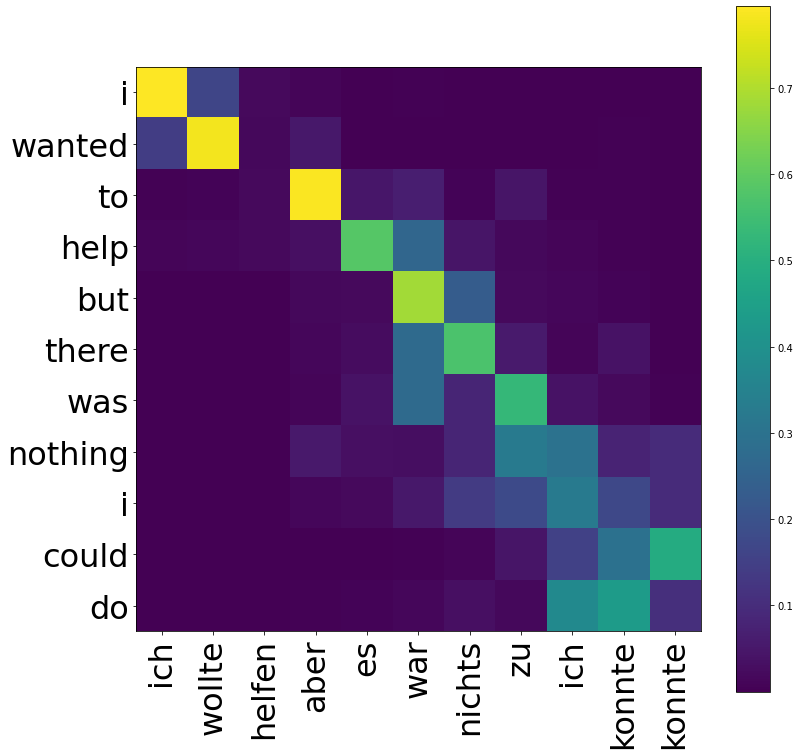

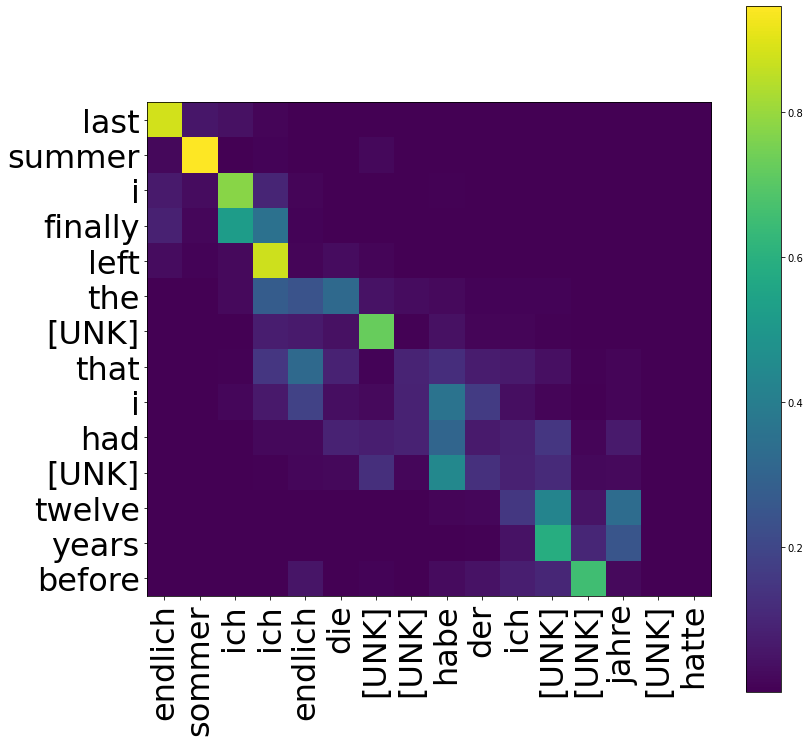

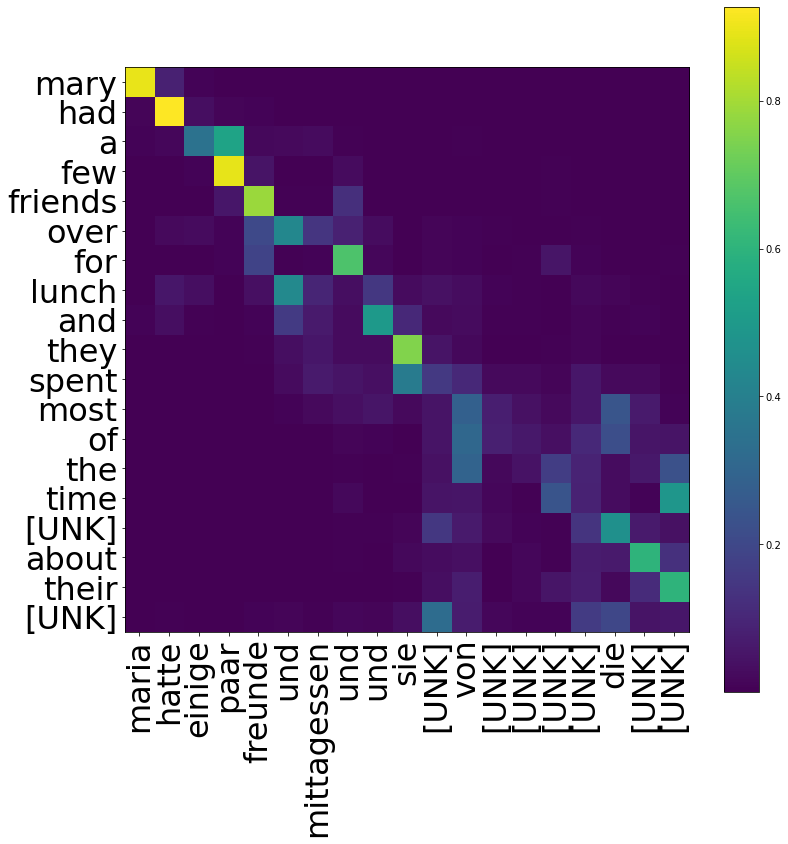

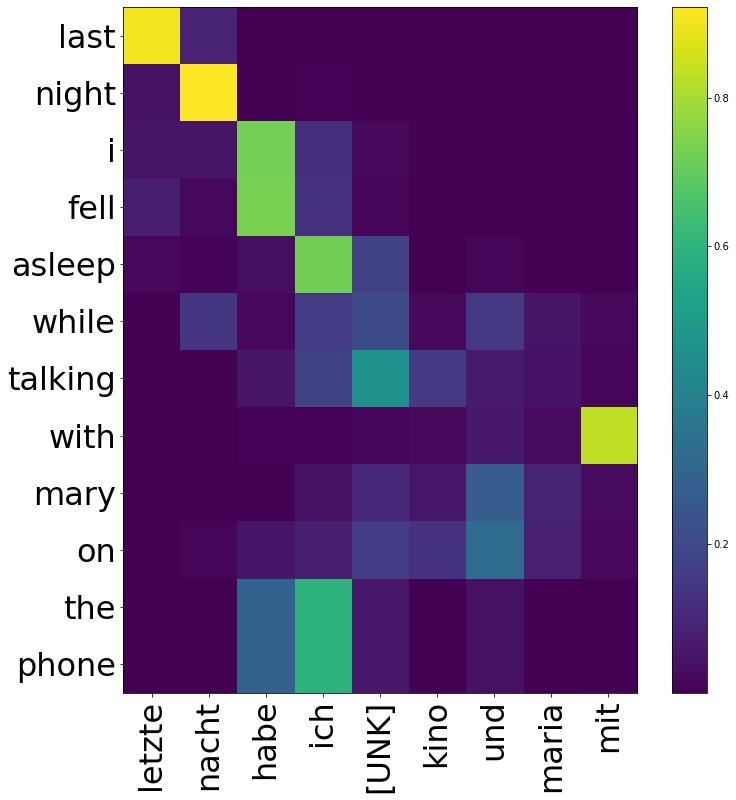

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_attention(visualizer_model, en_vocabulary, de_vocabulary, sample_en_text, sample_de_text, fig_savepath):

    print("Input: {}".format(sample_en_text))

    d_pred, attention_weights, e_out, d_out = visualizer_model.predict([np.array([sample_en_text]), np.array([sample_de_text])])
    
    d_pred_out = np.argmax(d_pred[0], axis=-1)

    y_ticklabels = []
    for e_id in e_out[0]:

        if en_vocabulary[e_id] == "":
            break
        y_ticklabels.append(en_vocabulary[e_id])
    
    x_ticklabels = []
    for d_id in d_pred_out:
        if de_vocabulary[d_id] == 'eos':
            break
        x_ticklabels.append(de_vocabulary[d_id])
            
    fig, ax = plt.subplots(figsize=(14, 14))
    attention_weights_filtered = attention_weights[0, :len(y_ticklabels), :len(x_ticklabels)]

    im = ax.imshow(attention_weights_filtered)
    
    ax.set_xticks(np.arange(attention_weights_filtered.shape[1]))
    ax.set_yticks(np.arange(attention_weights_filtered.shape[0]))

    ax.set_xticklabels(x_ticklabels)
    ax.set_yticklabels(y_ticklabels)

    ax.tick_params(labelsize=32)
    ax.tick_params(axis='x', labelrotation=90)

    save_dir, _ = os.path.split(fig_savepath)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    
    plt.colorbar(im)
    plt.subplots_adjust(left=0.2, bottom=0.2)
    plt.savefig(fig_savepath)
    
i = 0
j = 0
while j<4:
    sample_en_text = test_df["EN"].iloc[i]
    sample_de_text = test_df["DE"].iloc[i:i+1].str.rsplit(n=1, expand=True).iloc[:,0].tolist()
    i += 1
    
    if len(sample_en_text.split(" ")) > 10:
        j += 1
    else:
        continue
    
    visualize_attention(
        visualizer_model, en_vocabulary, de_vocabulary, sample_en_text, sample_de_text, os.path.join('plots','attention_{}.png'.format(i))
    )